In [1]:
import pandas as pd
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import matplotlib.pyplot as plt
import seaborn as sns
import string
import regex as re
import numpy as np
import pickle
from keras.models import load_model

In [2]:
df = pd.read_csv('train_preprocess.tsv', delimiter = '\t', header = None)
df.columns = ['tweet', 'sentiment']
df.head()

,tweet,sentiment
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [3]:
def cleaning_tweet(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'\d+',' ', text)
    return text

In [4]:
df['clean_tweet'] = df['tweet'].apply(lambda x: cleaning_tweet(x))

In [5]:
df['sentiment'].value_counts()

positive    6416
negative    3436
neutral     1148
Name: sentiment, dtype: int64

In [6]:
positif = df[df['sentiment']=='positive']
netral = df[df['sentiment']=='neutral']
negatif = df[df['sentiment']=='negative']

neu = netral.sample(negatif.shape[0], replace = True)

df = pd.concat([positif, neu, negatif])

In [7]:
df['sentiment'].value_counts()

positive    6416
neutral     3436
negative    3436
Name: sentiment, dtype: int64

In [8]:
X = df['clean_tweet']
y = df['sentiment']

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [10]:
max_features = 100000
tokenizer = Tokenizer(num_words = max_features, split=' ', lower=True)
tokenizer.fit_on_texts(X)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")
X = tokenizer.texts_to_sequences(X)


print("\nAfter tokenizing :\n{}".format(X[18]))

x_pad_sequences.pickle has created!

After tokenizing :
[10, 390, 2, 97, 37, 3620, 578, 1794, 832, 1, 4, 1261, 90, 1, 140, 314, 61, 197, 352, 671, 96, 353, 12, 10100, 10101, 10102, 7795, 12, 44, 5, 16, 2, 5, 12, 30, 10, 3, 20]


In [11]:
X = pad_sequences(X)
with open('x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")

print("\nAfter padding :\n{}".format(X[18]))
print("\nAfter padding :\n{}".format(X[19]))

x_pad_sequences.pickle has created!

After padding :
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0    10
   390     2    97    37  3620   578  1794   832     1     4  1261    90
     1   140   314    61   197   352   671    96   353    12 10100 10101
 10102  7795    12    44     5    16     2     5    12    30    10     3
    20]

After padding :
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
   72   63    8    6   34  167    8   81    2 1294    3   67   21  849
    7  167  190    2    6  151  149  215  589    1   75   37    3  316
    4  167    1   14    5 1720  864    1  989  165    9 

In [12]:
y = pd.get_dummies(y)
y = y.values
#with open('y_labels.pickle', 'wb') as handle:
    #pickle.dump(y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    #print("y_labels.pickle has created!")

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (10630, 85)
y_train (10630, 3)
X_test (2658, 85)
y_test (2658, 3)


In [15]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

In [16]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]
    
    # Create model architecture

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(SimpleRNN(units, dropout=0.8))
    model.add(Dense(3,activation='softmax'))
    # model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

    adam = optimizers.Adam(learning_rate = 0.0005)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                        validation_data=(X_test, y_test), verbose=1, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only
    
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds

average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", round(average_accuracy,4))


Epoch 1/50


333/333 [==============================] - 52s 145ms/step - loss: 0.7431 - accuracy: 0.6702 - val_loss: 0.5700 - val_accuracy: 0.7833
Epoch 2/50
333/333 [==============================] - 48s 143ms/step - loss: 0.4689 - accuracy: 0.8160 - val_loss: 0.3612 - val_accuracy: 0.8604
Epoch 3/50
333/333 [==============================] - 47s 142ms/step - loss: 0.3101 - accuracy: 0.8878 - val_loss: 0.2863 - val_accuracy: 0.8924
Epoch 4/50
333/333 [==============================] - 47s 142ms/step - loss: 0.2330 - accuracy: 0.9160 - val_loss: 0.2661 - val_accuracy: 0.8980
Epoch 5/50
333/333 [==============================] - 47s 140ms/step - loss: 0.1896 - accuracy: 0.9277 - val_loss: 0.2524 - val_accuracy: 0.9018
Epoch 6/50
333/333 [==============================] - 47s 140ms/step - loss: 0.1526 - accuracy: 0.9458 - val_loss: 0.2553 - val_accuracy: 0.8973
Epoch 7/50
333/333 [==============================] - 46s 140ms/step - loss: 0.1325 - accuracy: 0.9500 - val_loss: 0.2718 - val

In [19]:
model.save('NN.h5')

C:\Users\User\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


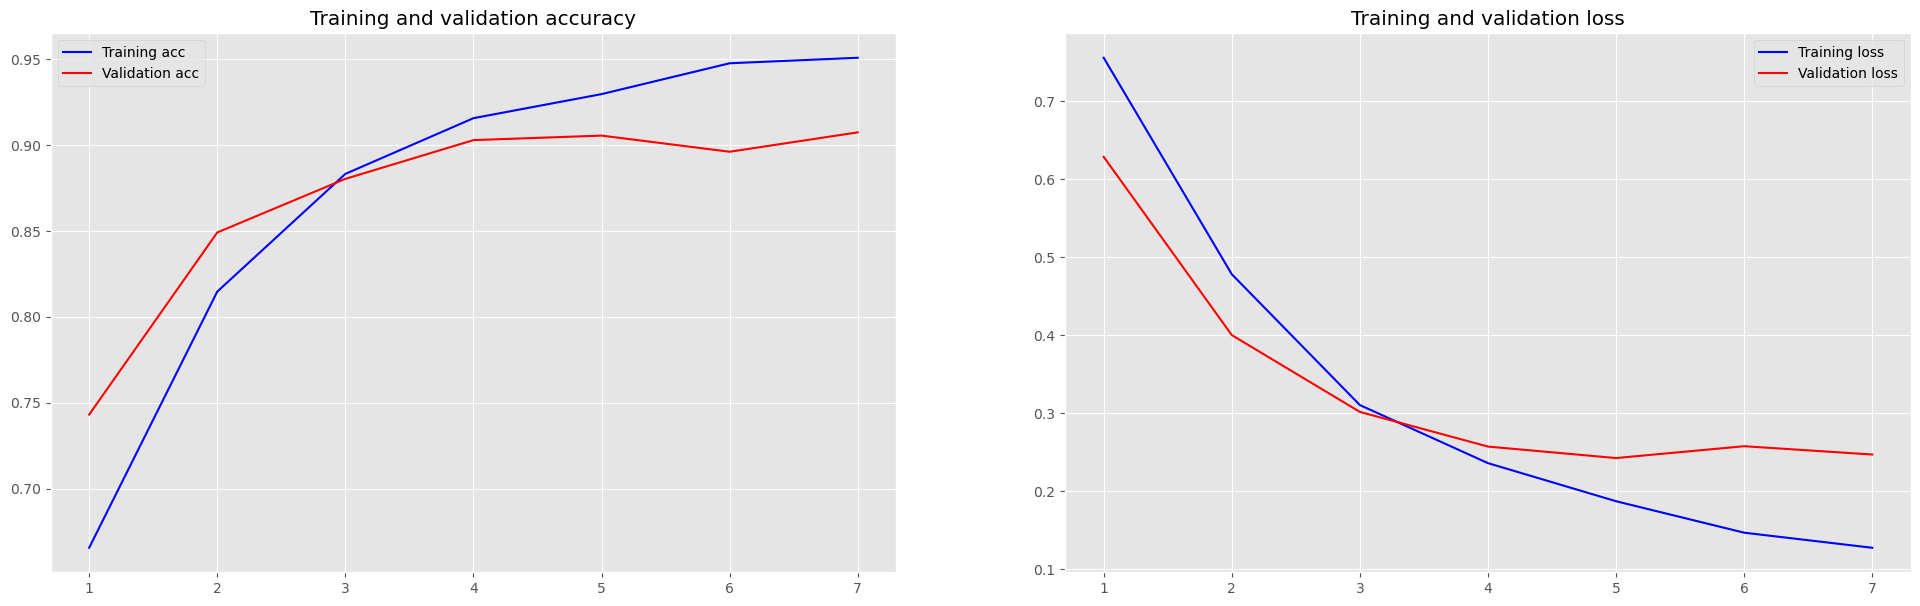

In [17]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(24, 7))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [24]:
input_text = """
jangan menyerah """

def cleansing(sent):
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('NN_MODEL/NN.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])
hasil = sentiment[polarity]

print("Text: %s" % text[0])
print("Sentiment: %s" % sentiment[polarity])

1/1 [==============================] - 0s 252ms/step
Text:  jangan menyerah 
Sentiment: negative
